Here are some results from publication "Electron ptychography achieves atomic-resolution limits set by lattice vibrations" are reproduced

This notebook is based upon abTEM example abTEM/examples/reconstruction/epie.ipynb

* When trying to reconstruct periodic structure (without any vacancies or dopants) the algorithm struggles to converge. Breaking translation symetry by deleting some atoms helps a lot in thin sample 1nm but in thicker sample it stops working and prob. more changes to the sample should be made. What helps a lot is using nonperiodic sample created by accounting for temperature effects by frozen phonons approximation. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
#from skimage import data

from abtem import GridScan, PixelatedDetector, Potential, Probe, show_atoms, SMatrix, AnnularDetector
from abtem.reconstruct import epie
from ase.build import mx2
from abtem.structures import orthogonalize_cell
from abtem.measure import bandlimit

In [2]:
from ase.visualize import view
from abtem import PotentialArray
from abtem.utils import energy2sigma

PrScO3 using the ePIE algorithm

We simulate a 4D-STEM dataset of MoS2 with a defect and perform a ptychographic reconstruction using the [ePIE](https://doi.org/10.1016/j.ultramic.2009.05.012) algorithm.

In [3]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20, 20)
matplotlib.rcParams['lines.linewidth'] = 2
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)

## Simulation

In [4]:
from ase.io import read
prsco3 = read('PrScO3_mp-559756_primitive.cif')

In [5]:
atoms=prsco3*(8,8,10)
view(atoms)

usage: ase [-h] [--version] [-T]
           {help,info,test,gui,db,run,band-structure,build,dimensionality,eos,ulm,find,nebplot,nomad-upload,nomad-get,convert,reciprocal,completion,diff,exec}
           ...
ase: error: ModuleNotFoundError: No module named 'tkinter'
To get a full traceback, use: ase -T gui ...


<Popen: returncode: None args: ['/usr/bin/python3', '-m', 'ase', 'gui', '-']>

In [6]:
##pro atoms = prsco3*(4,4,2) #1nm
#del atoms[221]
#del atoms[221]
#del atoms[201]
#del atoms[201]

##pro atoms = prsco3*(4,4,20) #16nm
#del atoms[2381]
#del atoms[2381]
#del atoms[2361]
#del atoms[2361]

#pro atoms = prsco3*(4,4,10) #8nm
del atoms[1181]
del atoms[1181]
del atoms[1161]
del atoms[1161]

#view(atoms)

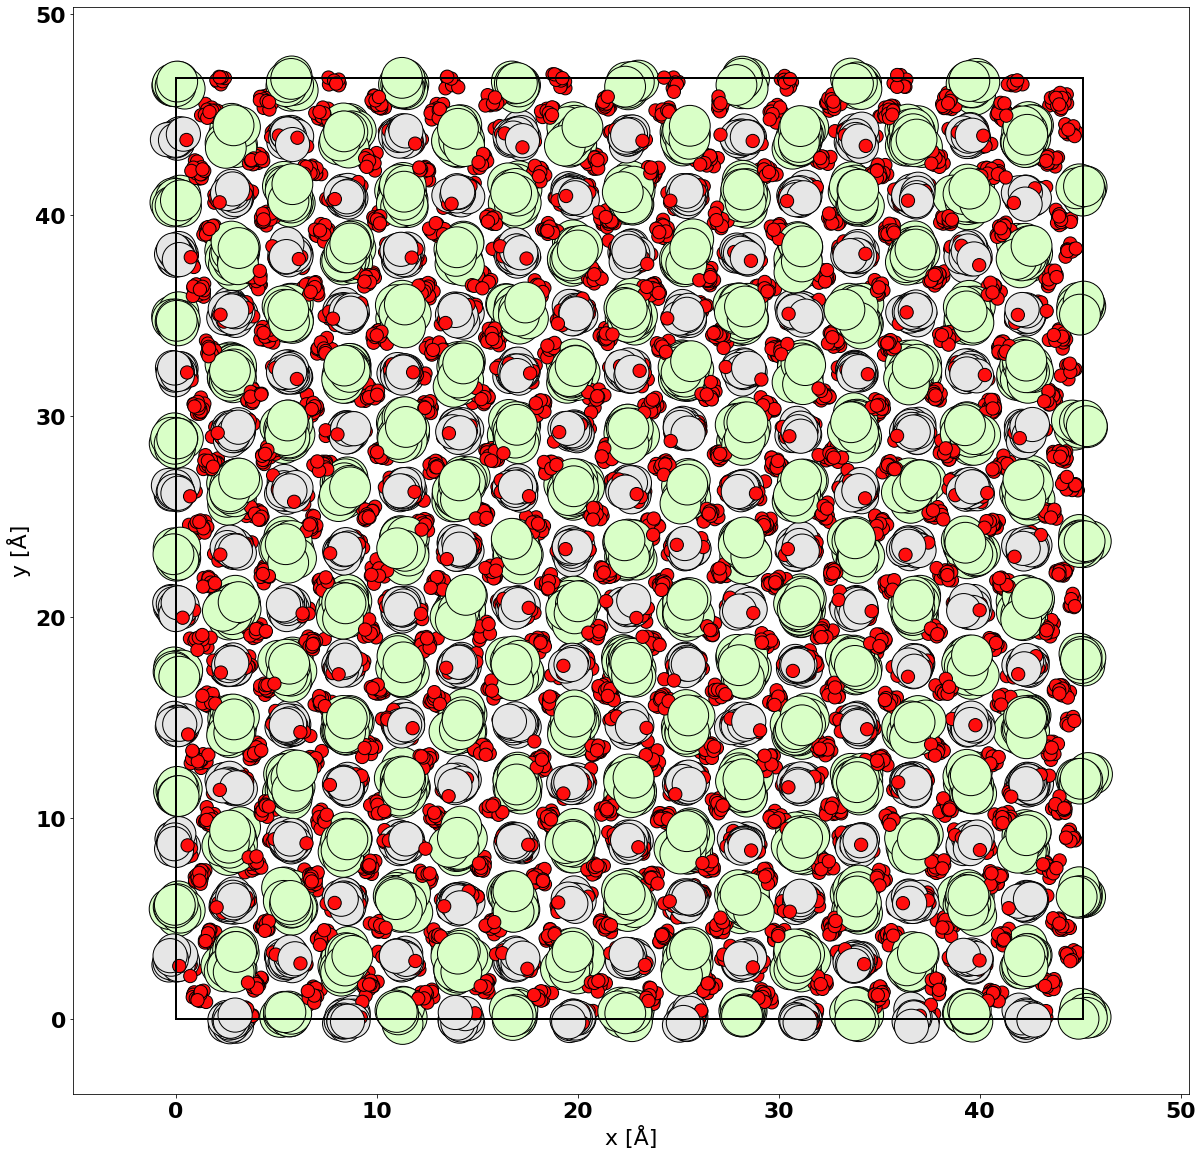

In [7]:
rs_sampling=0.09#S.wavelength/(256*0.856*1e-3)
if 0:
    potential = Potential(atoms, 
                          #gpts=256,
                          sampling=rs_sampling,
                          projection='infinite', 
                          slice_thickness=1, 
                          parametrization='kirkland').build()
else:
    from abtem.temperature import FrozenPhonons

    def B2sigma(B):
        return(np.sqrt(B*3/8/np.pi**2))

    B_Pr = 0.88
    B_Sc = 0.70
    B_O = 1.00

    sigma_Pr = B2sigma(B_Pr)
    sigma_Sc = B2sigma(B_Sc)
    sigma_O = B2sigma(B_O)

    sigmas = {'Pr': sigma_Pr, 'Sc': sigma_Sc, 'O': sigma_O} # standard deviations of thermal vibrations
    num_configs = 20 # number of frozen phonon configurations

    frozen_phonons = FrozenPhonons(atoms, num_configs=num_configs, sigmas=sigmas)
    potential = Potential(frozen_phonons, 
                          #gpts=256, 
                          sampling=rs_sampling,
                          slice_thickness=1, parametrization='kirkland', projection='infinite')

    atoms_conf = next(iter(frozen_phonons))

    show_atoms(atoms_conf)

In [8]:
#view(atoms_conf)

In [9]:
#proj_pot = potential.project().array
#potential = PotentialArray(proj_pot[None], [80], sampling=potential.sampling)

In [10]:
try:
    print(np.shape(potential.array)) # For potential obtained via PotentialArray
except:
    print(np.shape(potential.build().array)) #For normal potential

(82, 502, 520)


smaller (8,8,10)
* on laptop with 2 cores with device='cpu' it takes cca 3.5 min per phonon
* on lenc with 36 cores with device='cpu' it takes cca 2 min per phonon with utilasition of all cores (including virtual)
* on lenc with 36 cores with device='gpu' it takes cca 50 sec per phonon with utilisation of all cores and gpu 

In [11]:
%%time
energy=300e3
probe = Probe(semiangle_cutoff=21.4, energy=energy, defocus=-200, Cs=0, device='gpu')
probe.grid.match(potential)


center=np.array(potential.extent)/2
offset=np.array([16.1,16.6])/2 #== np.array([35,36])*0.46/2 number of steps*sampling/2

#gridscan = GridScan((0,0), np.array(potential.extent), sampling=0.46)
gridscan = GridScan(center-offset,center+offset, sampling=0.46)                    
detector = PixelatedDetector(None)
measurement = probe.scan(gridscan, [detector], potential, pbar=False)

CPU times: user 12h 50min 40s, sys: 2min 57s, total: 12h 53min 38s
Wall time: 16min 27s


In [12]:
np.shape(measurement)

(35, 36, 502, 520)

In [13]:
potential.gpts

(502, 520)

In [14]:
#energy=300e3
#S = SMatrix(semiangle_cutoff=21.4, energy=energy, defocus=-200, Cs=0, expansion_cutoff=25, device='cpu')
#S.grid.match(potential)


#center=np.array(potential.extent)/2
#offset=np.array([16.1,16.6])/2 #== np.array([35,36])*0.46/2 number of steps*sampling/2

##gridscan = GridScan((0,0), np.array(potential.extent), sampling=0.46)
#gridscan = GridScan(center-offset,center+offset, sampling=0.46)                    
#detector = PixelatedDetector()
#measurement = S.scan(gridscan, [detector], potential, pbar=False)

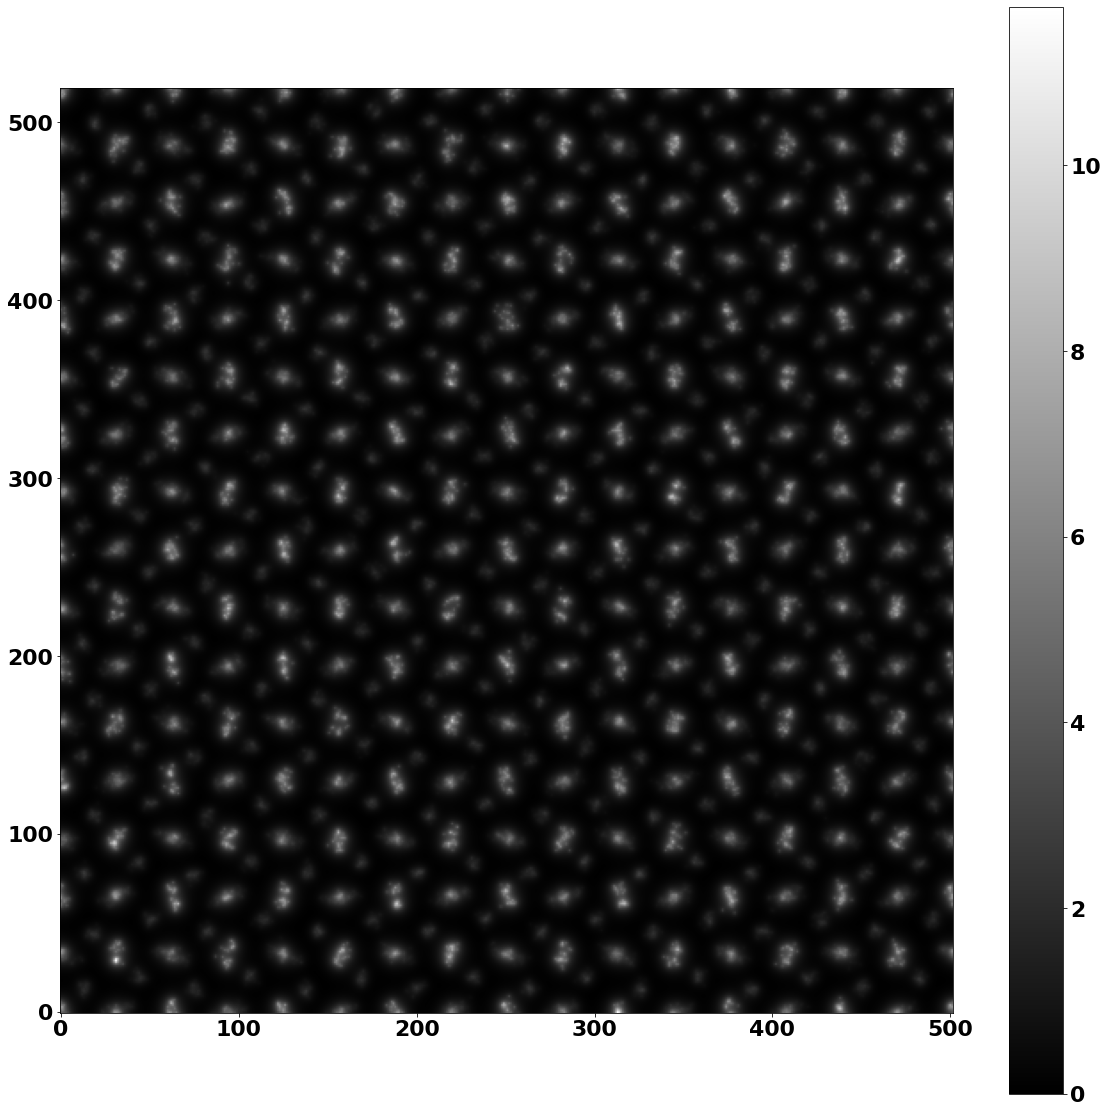

In [15]:
#%matplotlib inline
proj_pot = potential.project().array.astype(np.complex64) # in projected potential in eV*angstrom
interaction_parameter = energy2sigma(energy)
phase_shift=proj_pot*interaction_parameter 
plt.imshow(np.real(phase_shift).T, origin='lower', cmap='gray')
plt.colorbar()

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x7f1cb1457670>)

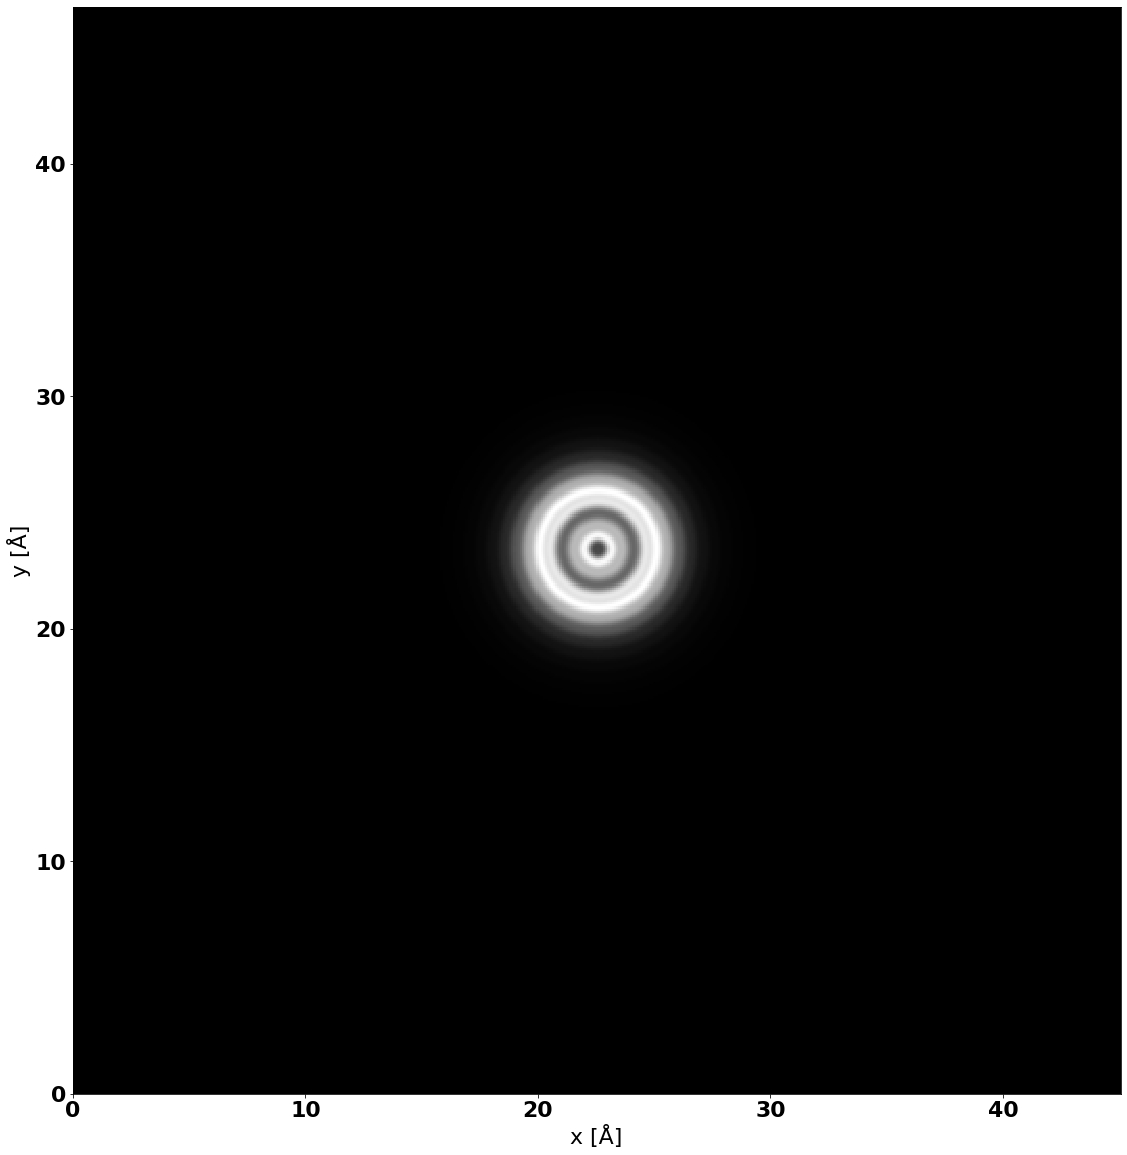

In [16]:
probe.show()

In [17]:
dx=(potential.extent[0]/potential.gpts[0])
max_a=probe.wavelength/dx
max_a

0.21891927500029437

In [18]:
probe.wavelength/potential.extent[0]

0.00043609417330735934

In [19]:
potential.extent

(45.14504, 46.844288)

In [20]:
np.array(potential.extent)/np.array(potential.gpts)

array([0.08993036, 0.09008517])

## Full-field reconstruction

We first do a full-field reconstruction, however, we may still need to bandlimit the measurement to some experimental maximum detector angle.

(<AxesSubplot:xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7f1ca1f38e80>)

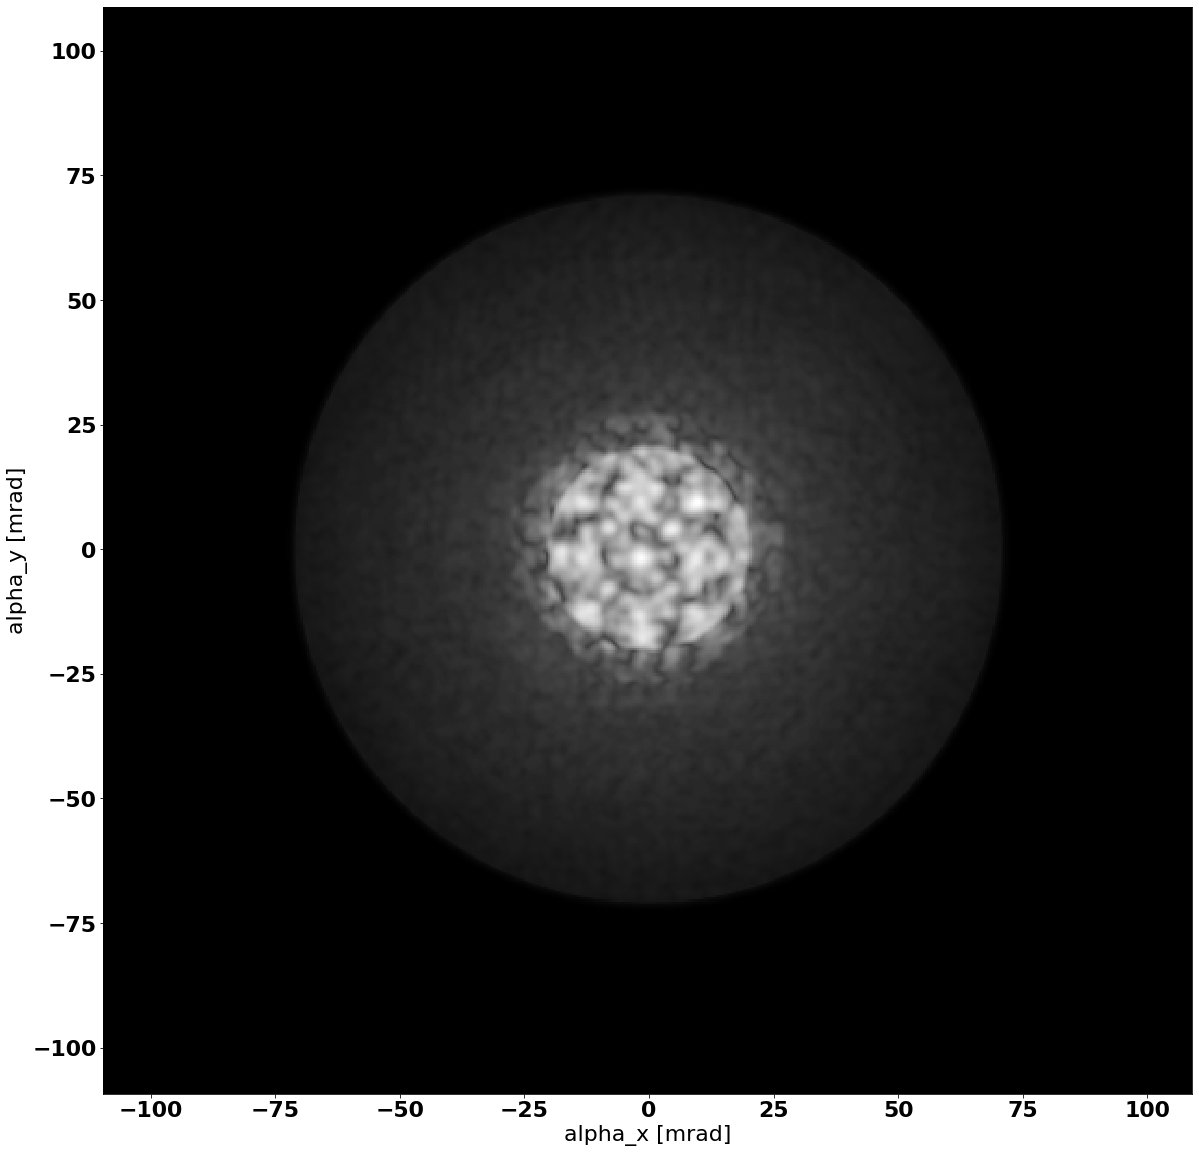

In [21]:
band_limited_measurment = bandlimit(measurement, 80)

band_limited_measurment[0,0].show(power=.25)

We make a probe guess, here we assume that all we know is probe semi-angle and energy. The probe will be optimized as well.

In [22]:
probe_guess = Probe(semiangle_cutoff=21.4, energy=energy)

In [23]:
np.shape(measurement.array)

(35, 36, 502, 520)

In [24]:
%%time
tmp=band_limited_measurment
reconstructions_full = epie(tmp, probe_guess, maxiter=16, return_iterations=True, fix_com=True,device='gpu')

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/1260 [00:00<?, ?it/s]

CPU times: user 1min 19s, sys: 25.8 s, total: 1min 44s
Wall time: 1min 44s


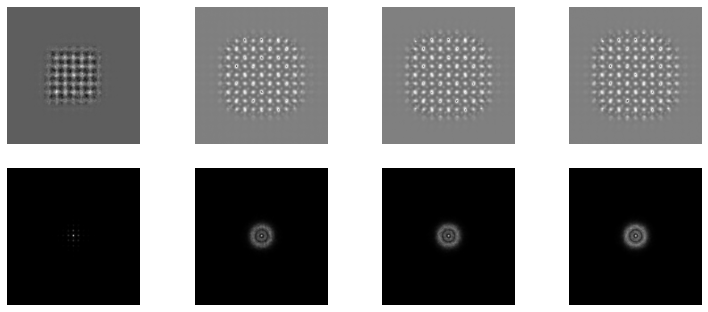

In [25]:
plot_every = 4

fig, axes = plt.subplots(2, int(np.ceil(len(reconstructions_full[0]) / plot_every)), figsize=(11,4.8))

for i, j in enumerate(range(0, len(reconstructions_full[0]), plot_every)):
    axes[0,i].imshow(np.angle(reconstructions_full[0][j].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions_full[1][j].array).T ** 2, origin='lower', cmap='gray')
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
    
plt.tight_layout()

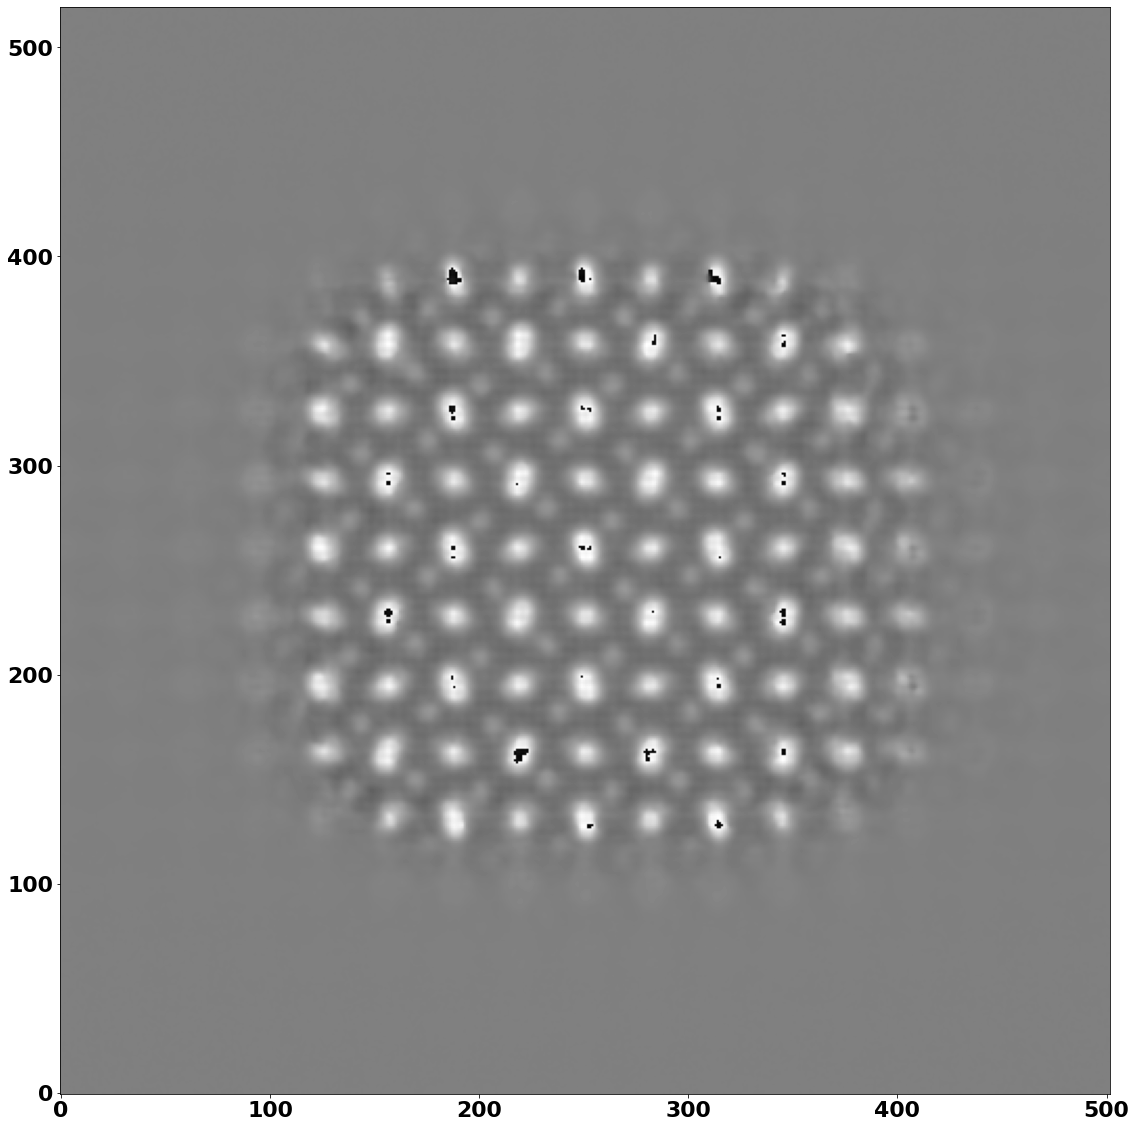

In [26]:
plt.imshow(np.angle(reconstructions_full[0][-14].array).T, origin='lower', cmap='gray')

In [27]:
#from skimage.restoration import unwrap_phase

#%matplotlib inline

#plt.imshow(unwrap_phase(np.angle(reconstructions_full[0][-1].array).T), origin='lower', cmap='gray')

In [28]:
r=reconstructions_full[0][0]

In [29]:
f=r.calibrations[0].sampling


## Bright-field reconstruction

Bright-field reconstruction can be performed by simply bandlimiting to the bright-field disk.

(<AxesSubplot:xlabel='alpha_x [mrad]', ylabel='alpha_y [mrad]'>,
 <matplotlib.image.AxesImage at 0x7f1ca1cf3370>)

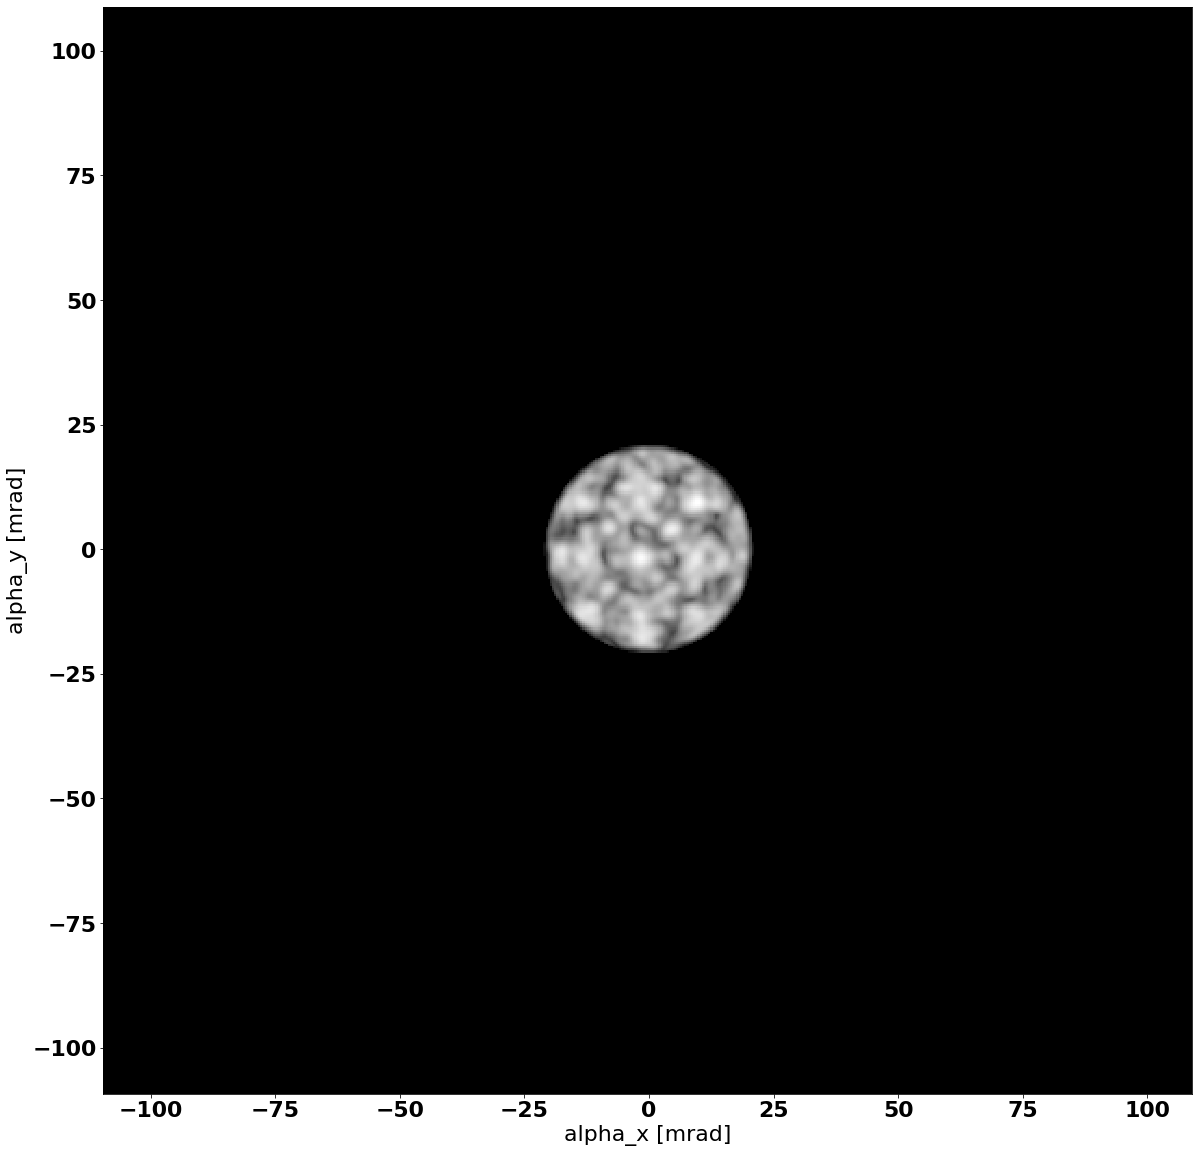

In [30]:
bright_field_measurment = bandlimit(measurement, 21)

#%matplotlib inline
bright_field_measurment[0,0].show(power=.25)

We find emperically that for bright-field reconstructions the step sizes of probe and image updates have to be significantly decreased.

In [31]:
tmp=bright_field_measurment
reconstructions_bright = epie(tmp, probe_guess, maxiter=4, alpha=1, beta=1, return_iterations=True, fix_com=True)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1260 [00:00<?, ?it/s]

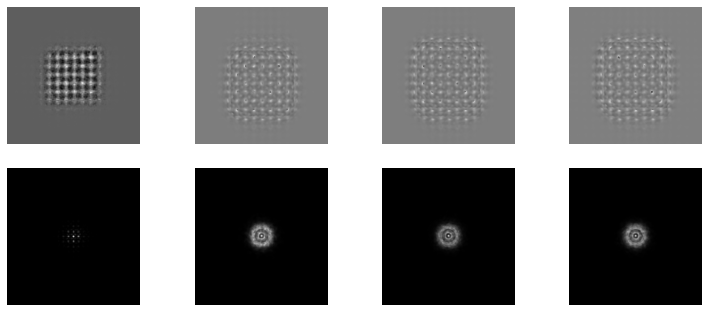

In [32]:
#%matplotlib qt
plot_every = 1

fig, axes = plt.subplots(2, int(np.ceil(len(reconstructions_bright[0]) / plot_every)), figsize=(11,4.8))

for i, j in enumerate(range(0, len(reconstructions_bright[0]), plot_every)):
    axes[0,i].imshow(np.angle(reconstructions_bright[0][j].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions_bright[1][j].array).T ** 2, origin='lower', cmap='gray')
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
    
plt.tight_layout()

In [33]:
np.shape(measurement.array)

(35, 36, 502, 520)

In [34]:
S.wavelength/(2*0.5)

NameError: name 'S' is not defined

In [ ]:
probe.wavelength/50e-3

In [43]:
from abtem.utils import fft_crop, fft_interpolate_2d, fft_interpolation_masks, fft_shift

In [124]:
ll=128
a,b=fft_interpolation_masks((2,2),(ll,ll),xp=np)
b=np.complex64(b)

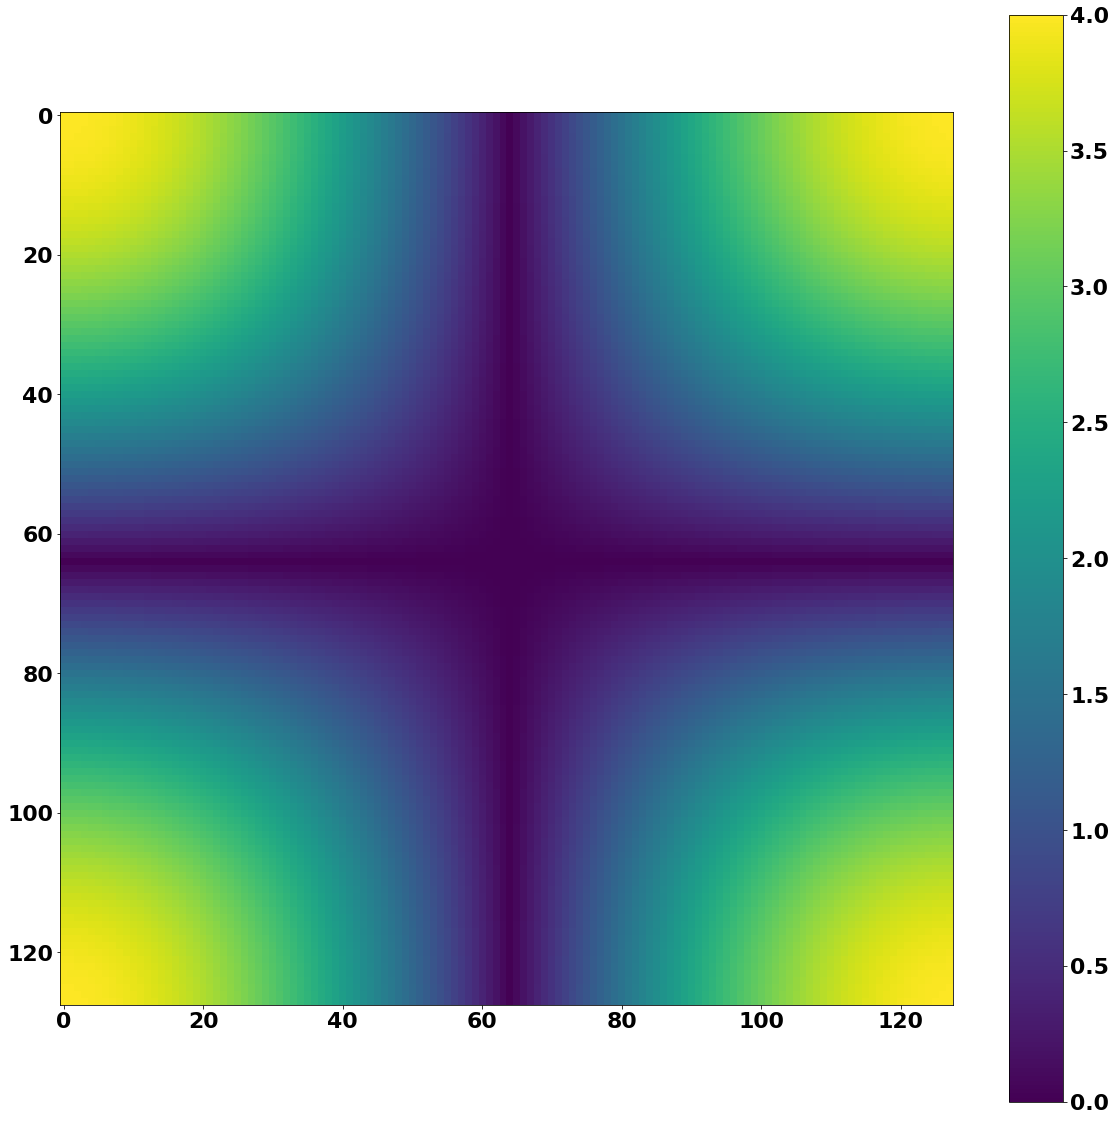

In [125]:
from abtem.utils import get_array_module,get_device_function
xp = get_array_module(b) 
fft2 = get_device_function(xp, 'fft2') 
ifft2 = get_device_function(xp, 'ifft2')
plt.imshow(np.abs(fft2(b)))
plt.colorbar()

In [64]:
b

array([[1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 1., 1.]])

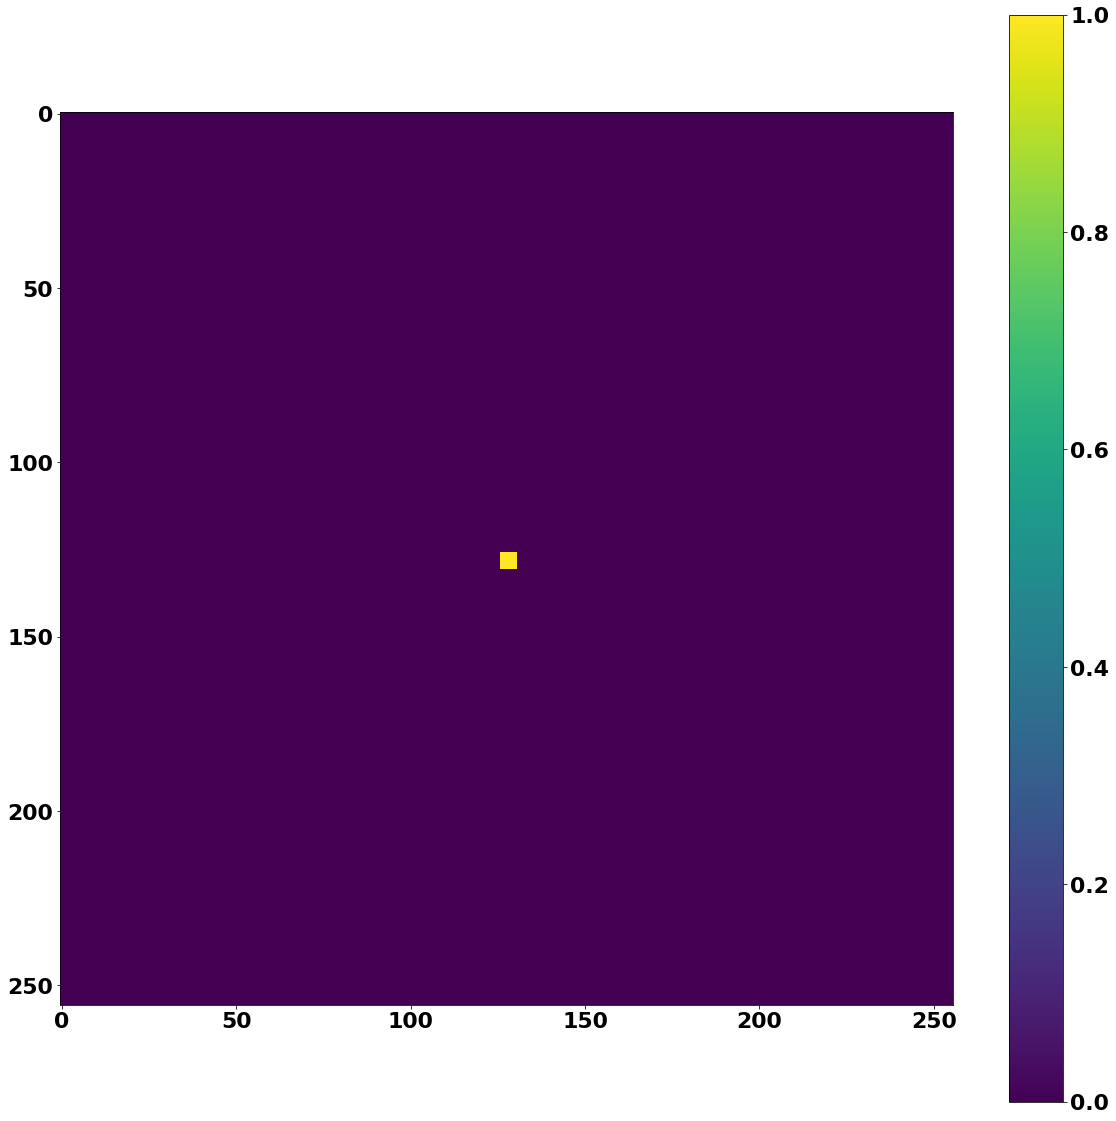

In [49]:
plt.imshow(np.abs(fft_shift(b,np.array((ll/2,ll/2))))); plt.colorbar()

In [ ]:
array=measurement[0,0].array
#ret=fft_crop(array,(100,100))
ret=fft_interpolate_2d(array,(256,256))

In [ ]:
np.shape(array)

In [ ]:
np.shape(ret)

In [ ]:
plt.imshow(array)

In [ ]:
plt.imshow(ret)

In [ ]:
S.wavelength/21e-3

In [ ]:
measurement.calibrations[0].sampling

In [ ]:
rec=reconstructions_full[1]

In [ ]:
rec[1].calibrations[0].sampling

In [ ]:
probe.wavelength/(52*1e-3)

In [ ]:
rec[1].calibrations[0].sampling

In [ ]:
probe.wavelength

In [ ]:
from abtem.measure import Measurement

In [35]:
np.shape(measurement)

(35, 36, 502, 520)

abtem.measure.Measurement